# Лабораторная работа №3: Numba

## Постановка задачи

1. Ускорить работу алгоритмов градиентного спуска с помощью функционала библиотеки Numba.
2. Определить прирост производительности.

## Реализация

Для каждого класса и метода реализован модифицированный двойник, с которым выполняется сравнение

## Источники

* [Плейлист по NumPy](https://youtube.com/playlist?list=PLA0M1Bcd0w8zmegfAUfFMiACPKfdW4ifD)
* [Плейлист по Matplotlib](https://youtube.com/playlist?list=PLA0M1Bcd0w8xQx-X5a6eSEOYULNSnHN_p)
* [Статья по Numba](https://habr.com/ru/post/484136/)


# Подключение зависимостей

In [294]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as la
import numba
from datetime import datetime

# Тестовые функции

## Функция Сферы
* Функция: $f(\boldsymbol{x}) = \sum_{i=1}^{n} x_{i}^{2}$
* Область определения: $ -\infty \le x_{i} \le \infty$
* Глобальный минимум: $f(x_{1}, \dots, x_{n}) = f(0, \dots, 0) = 0$

In [295]:
class Sphere:

    @staticmethod
    def fitness(x: np.ndarray):
        return x[0]*x[0] + x[1]*x[1]

    @staticmethod
    def get_bounds():
        return np.array([[-3., -3.], [3., 3.]])

    @staticmethod
    def get_glob_min():
        return np.array([0., 0., 0.])
    
    @staticmethod
    def get_default_start_point():
        return np.array([2.0, 2.7])

In [296]:
class SphereFast:

    @staticmethod
    @numba.njit(fastmath=True)
    def fitness(x: np.ndarray):
        return x[0]*x[0] + x[1]*x[1]

    @staticmethod
    @numba.njit(fastmath=True)
    def get_bounds():
        return np.array([[-3., -3.], [3., 3.]])

    @staticmethod
    @numba.njit(fastmath=True)
    def get_glob_min():
        return np.array([0., 0., 0.])

    @staticmethod
    @numba.njit(fastmath=True)
    def get_default_start_point():
        return np.array([2.0, 2.7])

## Функция Мак Кормика
* Функция: $f(x,y) = \sin \left(x+y\right) + \left(x-y\right)^{2} - 1.5x + 2.5y + 1$
* Область определения: $-1.5\le x \le 4 \:and\: -3\le y \le 4$
* Глобальный минимум: $f(-0.54719,-1.54719) = -1.9133$

In [480]:
class McCormick:

    @staticmethod
    def fitness(x: np.ndarray):
        return np.sin(x[0] + x[1]) + (x[0] - x[1]) ** 2 - 1.5 * x[0] + 2.5 * x[1] + 1

    @staticmethod
    def get_bounds():
        return np.array([[-1.5, -3.], [5., 4.]])

    @staticmethod
    def get_glob_min():
        return np.array([-0.54719, -1.54719, -1.9133])

    @staticmethod
    def get_default_start_point():
        return np.array([-1.0, 3.0])

In [481]:
class McCormickFast:

    @staticmethod
    @numba.njit(fastmath=True)
    def fitness(x: np.ndarray):
        return np.sin(x[0] + x[1]) + (x[0] - x[1]) ** 2 - 1.5 * x[0] + 2.5 * x[1] + 1

    @staticmethod
    @numba.njit(fastmath=True)
    def get_bounds():
        return np.array([[-1.5, -3.], [5., 4.]])

    @staticmethod
    @numba.njit(fastmath=True)
    def get_glob_min():
        return np.array([-0.54719, -1.54719, -1.9133])
    
    @staticmethod
    @numba.njit(fastmath=True)
    def get_default_start_point():
        return np.array([-1.0, 3.0])

# Вспомогательные функции

## Вычисление градиента

In [299]:
def grad(fun: callable, point: np.ndarray, dt: float = 0.00001) -> np.array:
    
    """Вычисляет градиент функции в точке

    Args:
        fun (callable): Функция искуственного ландшавта
        point (np.ndarray): Точка (массив параметров)
        dt (float, optional): Изменение аргумента. Defaults to 0.00001.

    Returns:
        np.array: градиент
    """

    dxdt = (fun(point + np.array([dt, 0])) - fun(point)) / dt
    dydt = (fun(point + np.array([0, dt])) - fun(point)) / dt
    return np.array([dxdt, dydt])

## Вычисление градиента c Numba

In [300]:
@numba.njit(fastmath=True)
def grad_fast(fun: callable, point: np.ndarray, dt: float = 0.00001) -> np.array:
    
    """Вычисляет градиент функции в точке

    Args:
        fun (callable): Функция искуственного ландшавта
        point (np.ndarray): Точка (массив параметров)
        dt (float, optional): Изменение аргумента. Defaults to 0.00001.

    Returns:
        np.array: Градиент
    """

    dxdt = (fun(point + np.array([dt, 0])) - fun(point)) / dt
    dydt = (fun(point + np.array([0, dt])) - fun(point)) / dt
    return np.array([dxdt, dydt])

# Cравнение времени выполнения

In [496]:
def compare_execution_time(default_method, default_prob, numba_method, numba_prob, measurements_count: int = 10):
    
    """Сравнивает результаты обычного и ускоренного методов оптимизации

    Args:
        default_method (_type_): Метод оптимизации
        default_prob (_type_): Класс проблемы
        numba_method (_type_): Модифицированный (ускоренный) метод оптимизации
        numba_prob (_type_): Класс проблемы с модифицированными (ускоренными) методами
        measurements_count (int, optional): Кол-во сравнений. Defaults to 10.
    """
    
    default_ex_time_list = []
    numba_ex_time_list = []

    for i in range(measurements_count):

        start = datetime.now()
        path = default_method(default_prob.fitness, default_prob.get_default_start_point(), default_prob.get_glob_min(), max_iter=1024, lr=0.01, delta=0.0001)
        default_ex_time_list.append((datetime.now() - start).total_seconds())

        start = datetime.now()
        path = numba_method(numba_prob.fitness, numba_prob.get_default_start_point(), numba_prob.get_glob_min(), max_iter=1024, lr=0.01, delta=0.0001)
        numba_ex_time_list.append((datetime.now() - start).total_seconds())

    x = np.linspace(0, measurements_count, measurements_count)
    default_ex_time_list = np.array(default_ex_time_list)
    numba_ex_time_list = np.array(numba_ex_time_list)
    
    speed_up = default_ex_time_list / numba_ex_time_list

    fig = plt.figure(figsize=(22, 6))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    ax1.plot(x, default_ex_time_list, c="tab:blue", label = "Время выполнения без Numba")
    ax1.plot(x, np.full(measurements_count, np.mean(default_ex_time_list)), '--', c="tab:blue", label = "Среднее время без Numba")
    ax1.plot(x, numba_ex_time_list, c="tab:orange", label = "Время выполнения с Numba")
    ax1.plot(x, np.full(measurements_count, np.mean(numba_ex_time_list)), '--', c="tab:orange", label = "Среднее время с Numba")
    ax1.set_xlabel("Измерение")
    ax1.set_ylabel("Время выполнения (с)")
    ax1.set_title(f"Время выполнения {default_method.__name__.upper()} на {default_prob.__name__}", fontsize = 14, pad=14)
    ax1.legend()

    ax2.plot(x, speed_up, c="tab:red", label = "Прирост производительности")
    ax2.plot(x,  np.full(measurements_count, np.mean(speed_up)), '--', c="tab:red", label = "Средний прирост производительности")
    ax2.set_xlabel("Измерение")
    ax2.set_ylabel("Коэффициент")
    ax2.set_title("Прирост производительности", fontsize = 14, pad=14)
    ax2.legend()

# Методы оптимизации

## Классический градиентный спуск 

In [301]:
def classic_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001
    ) -> np.array:

    """Классический градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params = params - lr * grad(fun, params)

        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

## Классический градиентный спуск c Numba

In [302]:
@numba.njit(fastmath=True)
def classic_GD_fast(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001
    ) -> np.array:

    """Классический градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params = params - lr * grad_fast(fun, params)

        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

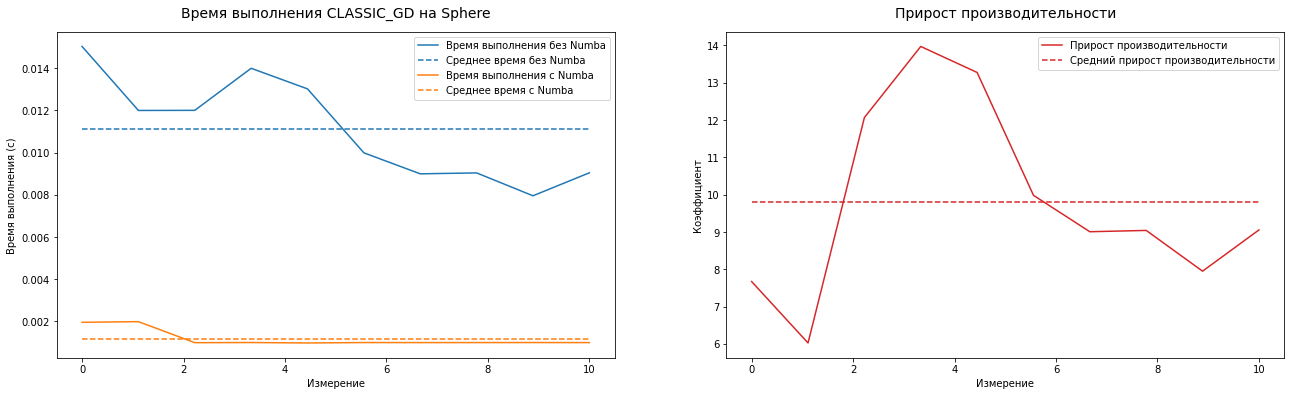

In [497]:
compare_execution_time(classic_GD, Sphere, classic_GD_fast, SphereFast)

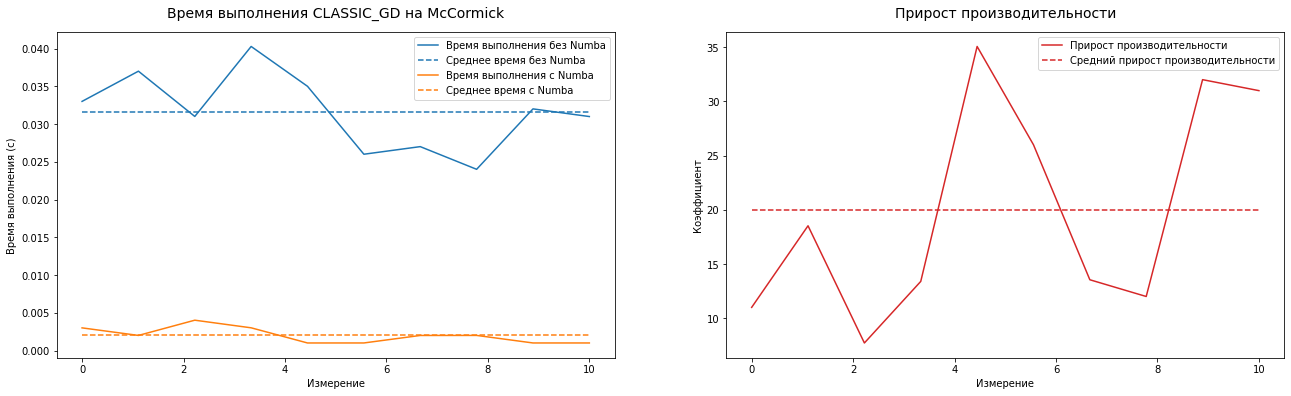

In [498]:
compare_execution_time(classic_GD, McCormick, classic_GD_fast, McCormickFast)

## Инертный градиентный спуск

In [488]:
def inertial_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001, beta: float = 0.5
    ) -> np.array:
    
    """Инертный градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.
        beta (float, optional): Коэффициент энертности. Defaults to 0.5.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params_prev = start_params.copy()
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params_new = params - lr * grad(fun, params) + beta * (params - params_prev)
        params_prev = params
        params = params_new
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

## Инертный градиентный спуск c Numba

In [491]:
@numba.njit(fastmath=True)
def inertial_GD_fast(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001, beta: float = 0.5
    ) -> np.array:
    
    """Инертный градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.
        beta (float, optional): Коэффициент энертности. Defaults to 0.5.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params_prev = start_params.copy()
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params_new = params - lr * grad_fast(fun, params) + beta * (params - params_prev)
        params_prev = params
        params = params_new
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

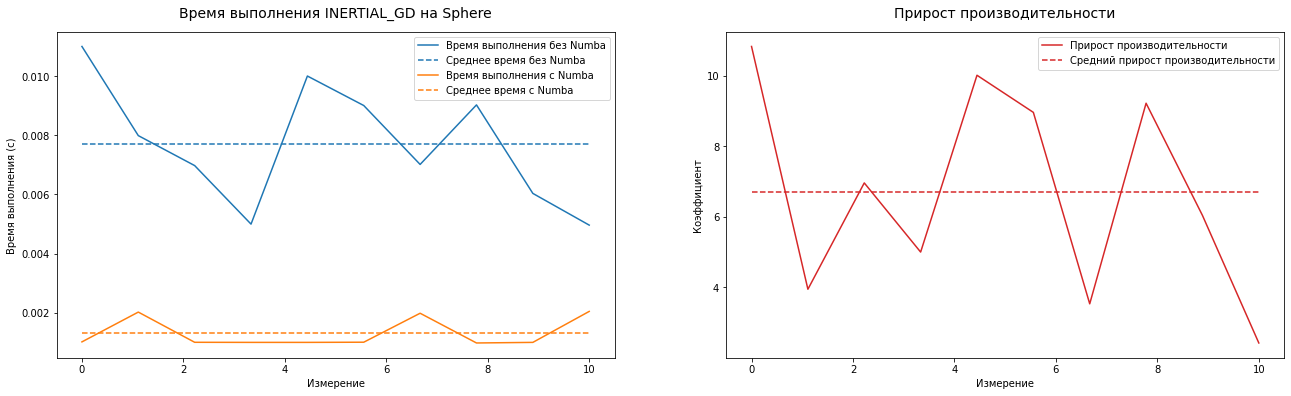

In [509]:
compare_execution_time(inertial_GD, Sphere, inertial_GD_fast, SphereFast)

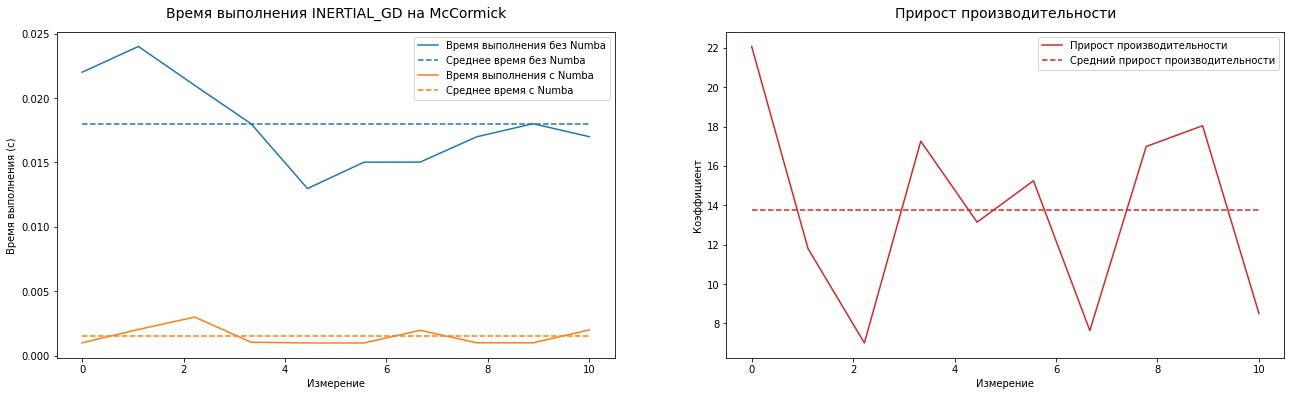

In [507]:
compare_execution_time(inertial_GD, McCormick, inertial_GD_fast, McCormickFast)

## Адаптивный градиентный спуск

In [513]:
def adam_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, max_iter: int = 256, 
    lr: float = 0.1, b1: float = 0.6, b2: float = 0.999, e: float = 10e-8, delta: float = 0.001
    ) -> np.array:
    
    """Адаптивный градиентный спуск: Adam

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 256.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        b1 (float, optional): Параметр beta1. Defaults to 0.6.
        b2 (float, optional): Параметр beta2. Defaults to 0.999.
        e (float, optional): "Бесконечно малое" число. Defaults to 10e-8.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]

    # Инициализируем первый и второй моменты
    m = np.array([0, 0])
    v = np.array([0, 0])
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):
        
        # Считаем первый первый и второй моменты
        m = b1 * m + (1 - b1) * grad(fun, params)
        v = b2 * v + (1 - b2) * grad(fun, params) ** 2

        # Вычисляем новое значение параметров
        params = params - lr * m / (np.sqrt(v) + e)
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

## Адаптивный градиентный спуск c Numba

In [519]:
@numba.njit(fastmath=True)
def adam_GD_fast(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, max_iter: int = 256, 
    lr: float = 0.1, b1: float = 0.6, b2: float = 0.999, e: float = 10e-8, delta: float = 0.001
    ) -> np.array:
    
    """Адаптивный градиентный спуск: Adam

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 256.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        b1 (float, optional): Параметр beta1. Defaults to 0.6.
        b2 (float, optional): Параметр beta2. Defaults to 0.999.
        e (float, optional): "Бесконечно малое" число. Defaults to 10e-8.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]

    # Инициализируем первый и второй моменты
    m = np.array([0., 0.])
    v = np.array([0., 0.])
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):
        
        # Считаем первый первый и второй моменты
        m = b1 * m + (1. - b1) * grad_fast(fun, params)
        v = b2 * v + (1. - b2) * grad_fast(fun, params) ** 2

        # Вычисляем новое значение параметров
        params = params - lr * m / (np.sqrt(v) + e)
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return path

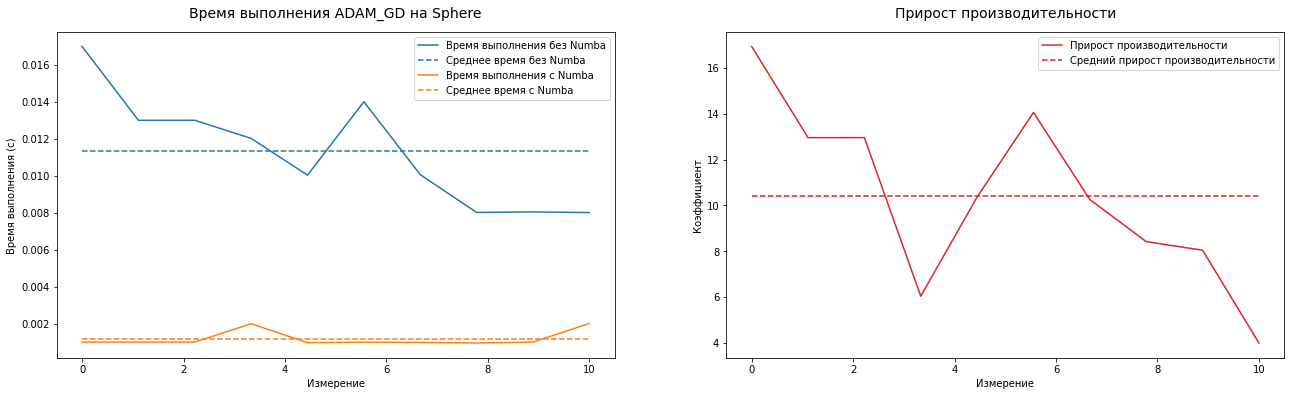

In [521]:
compare_execution_time(adam_GD, Sphere, adam_GD_fast, SphereFast)

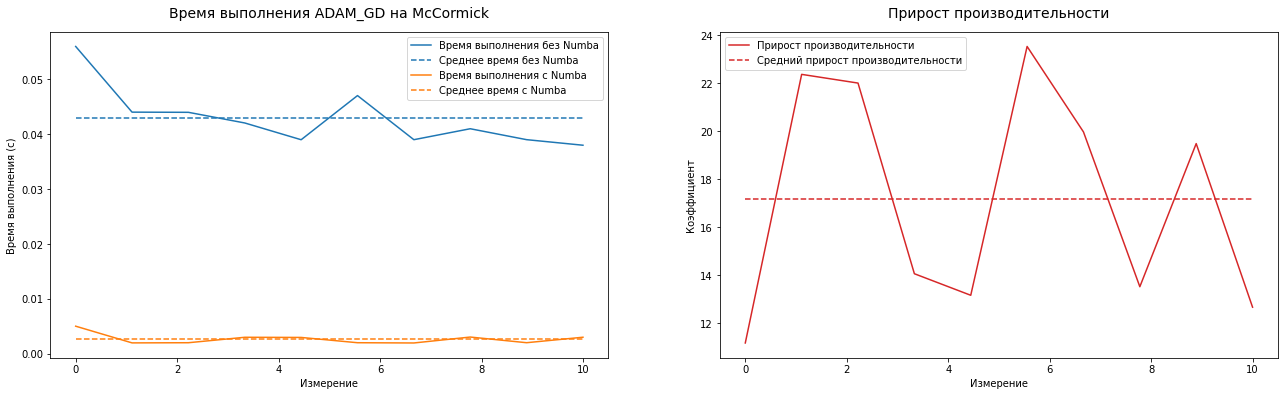

In [523]:
compare_execution_time(adam_GD, McCormick, adam_GD_fast, McCormickFast)